In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Загрузим датасет
mnist = fetch_openml('mnist_784', as_frame=False, cache=True)

# подготовим данные в нужном формате
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

# Оставим в датасете только классы 0 и 1
y_bin = y[(y == 0) | (y == 1)]
X_bin = X[(y == 0) | (y == 1)]


# Для удобства, обозначим лейблы классов за -1 (обозначает цифру 0)
# и 1 (обозначает цифру 1)
y_bin[y_bin == 0] = -1

# Посмотрим на долю единиц в датасете
positive_class_size = len(y_bin[y_bin == 1])
positive_class_rate = positive_class_size / len(y_bin)

print("Доля единиц в датасете: ", positive_class_rate)

Доля единиц в датасете:  0.5329499323410013


In [3]:
print(len(X_bin))

14780


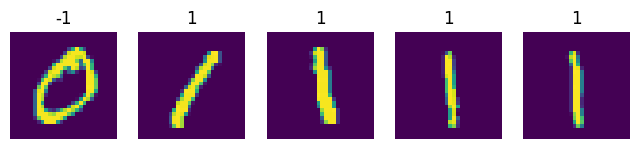

In [4]:
# Посмотрим на первые 5 примеров

n = 5

fig, axs = plt.subplots(1, n, figsize=(8, 4))

for ax, image, label in zip(axs, X_bin[:n], y_bin[:n]):

  # Переводим картинку из вектора длины 784 в матрицу 28 x 28
  image_reshaped = image.reshape(28, 28)

  ax.imshow(image_reshaped)
  ax.set_title(label)
  ax.axis("off")

Разделим множество пар данных на обучаемые и тестовые

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X_bin, y_bin, test_size=0.2)
X_train.shape, X_test.shape

((11824, 784), (2956, 784))

**Нормализуем датасет** так, чтобы значения каждого пикселя были в диапазоне [0, 1].

Почему бы просто не поделить на 255 весь обучающий датасет, ведь у нас 8-битные изображения?

In [6]:
from sklearn.preprocessing import MinMaxScaler

tran = MinMaxScaler()
tran.fit(X_train)
# Выход numpy матрица, положим ее в новую переменную
X_train_normal = tran.transform(X_train)

#X_train = X_train/255

Обучим модель

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression()
logreg.fit(X_train_normal, y_train)

LogisticRegression()

Посчитаем точность модели на тестовой выборке

In [8]:
y_pred = logreg.predict(X_test)
print(f'Accuracy of logistic regression classifier on test set: {accuracy_score(y_pred, y_test)}')

Accuracy of logistic regression classifier on test set: 0.9969553450608931


Атакуем незащищенную модель

Вычислимм значения оптимальной атаки $\delta^\star$ для каждого класса (-1 и 1)

\begin{equation}
\delta^\star = - y \cdot \epsilon \cdot \mathrm{sign}(w),
\end{equation}

(1, 784)
784


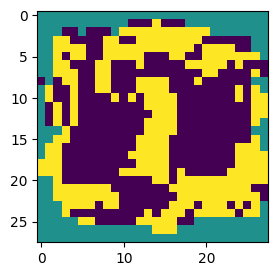

In [9]:
w = logreg.coef_
w.tolist
delta_minus = 0.2*np.sign(w)

#изобразим нашу атаку_1

image_delta_minus = delta_minus.reshape(28, 28)
fig, axs = plt.subplots(1, 1, figsize=(7, 3))
axs.imshow(image_delta_minus)

print(delta_minus.size)

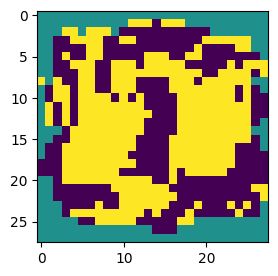

In [10]:
delta_plus = -0.2*np.sign(w)

#изобразим нашу атаку_2

image_delta_plus = delta_plus.reshape(28, 28)
fig, axs = plt.subplots(1, 1, figsize=(7, 3))
axs.imshow(image_delta_plus)

Нормализуем тестовую выборку и применим атаку к каждому изображению

(2956, 784)


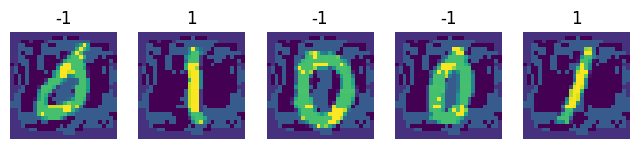

In [11]:
tran = MinMaxScaler()
tran.fit(X_test)
X_test_normal = tran.transform(X_test)
print(X_test_normal.shape)

#Проатакуем
X_test_attack_1 = np.atleast_2d(delta_minus).repeat(repeats=2956, axis=0)
X_test_attack_1 = X_test_normal + X_test_attack_1

n = 5

fig, axs = plt.subplots(1, n, figsize=(8, 4))

for ax, image, label in zip(axs, X_test_attack_1[:n], y_test[:n]):

  image_reshaped = image.reshape(28, 28)

  ax.imshow(image_reshaped)
  ax.set_title(label)
  ax.axis("off")

Посчитаем точность незащищенной модели на проатакованных тестовых изображениях

In [12]:
y_pred_attack_1 = logreg.predict(X_test_attack_1)
print(f'Accuracy of logistic regression classifier on test set: {accuracy_score(y_pred_attack_1, y_test)}')

Accuracy of logistic regression classifier on test set: 0.6874154262516915


Атака другого класса

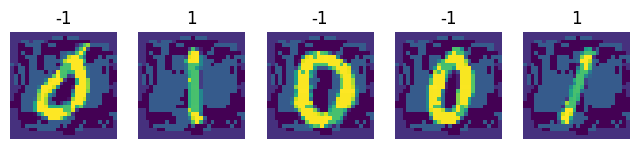

In [13]:
#Проатакуем
X_test_attack_2 = np.atleast_2d(delta_plus).repeat(repeats=2956, axis=0)
#np.repeat(delta_minus, repeats=X_test_normal.shape, axis=0)
X_test_attack_2 = X_test_normal + X_test_attack_2

n = 5

fig, axs = plt.subplots(1, n, figsize=(8, 4))

for ax, image, label in zip(axs, X_test_attack_2[:n], y_test[:n]):

  # Переводим картинку из вектора длины 784 в матрицу 28 x 28
  image_reshaped = image.reshape(28, 28)

  ax.imshow(image_reshaped)
  ax.set_title(label)
  ax.axis("off")

Также посчитаем точность незащищенной модели на проатакованных тестовых изображениях

In [14]:
y_pred_attack_2 = logreg.predict(X_test_attack_2)
print(f'Accuracy of logistic regression classifier on test set: {accuracy_score(y_pred_attack_2, y_test)}')

Accuracy of logistic regression classifier on test set: 0.4736129905277402


Напишем защиту модели с функцией потерь

\begin{equation}
\DeclareMathOperator*{\minimize}{minimize}
\minimize_{w,b} \frac{1}{D}\sum_{(x,y) \in D} L \left(y \cdot (w^Tx + b) - \epsilon \|w\|_1 \right ).
\end{equation}

Тренировка Robust Classifier

In [15]:
def L_derivative(z):
  return -np.exp(-z)/(1 + np.exp(-z))

def Loss(X, y, e_1, e_2):
  Los = 0
  for i in range(len(X[:1])):
    Los = Los + np.log(1+np.exp(- y[i]*(X[i] @ (e_1).T + e_2)))
  return Los

In [175]:
from sklearn.base import BaseEstimator

class RobustLogisticRegression(BaseEstimator):

    def __init__(self):
        super(RobustLogisticRegression, self).__init__()#Для инициализации унаследованных свойств вызываем метод инициализации родительского класса

        self.w = np.random.randn(784)*0.01 #Веса модели (обучаемые параметры)
        self.b = np.random.randn() #Сдвиг линейной модели (обучаемые параметры)
        self.report_every = 40


    def fit(self, X, y, learning_rate=0.05, epochs=600):
        """Метод для тренировки модели по тренировочным данным X и y"""

        for epoch in range(epochs):

          #Найдём градиент Лосс функции по вектору w весов модели
          L_w = np.zeros(784)
          L_b = 0

          for i in range(len(X[:1])):
            L_w = L_w + L_derivative(y[i]*(X[i] @ (self.w).T + self.b) - 0.2*np.linalg.norm(self.w, ord=1))*y[i]*self.w
            L_b = L_b + L_derivative(y[i]*(X[i] @ (self.w).T + self.b) - 0.2*np.linalg.norm(self.w, ord=1))*y[i]

          #Подсчёт новых значений параметров (шаг грдиентного спуска)
          self.w = self.w - learning_rate*L_w
          self.b = self.b - learning_rate*L_b

          L = Loss(X, y, self.w, self.b)
          #print(L)

          if epoch % self.report_every == 0:
            L = Loss(X, y, self.w, self.b)
            print(L)

    def predict(self, X):
        """Метод для предсказания классов для данных X"""
        y_pred = X @ (self.w).T + self.b
        for i in range(len(y_pred)):
          if (y_pred[i] >= 0):
            y_pred[i] = 1
          else:
            y_pred[i] = -1
        return y_pred

In [176]:
roblogreg = RobustLogisticRegression()
roblogreg.fit(X_train, y_train)

47.052365415279574
4.085011068949953
0.2593046924056247
0.11858526201101706
0.0790390531893793
0.06020764525344947
0.0490813098073812
0.041681267674684455
0.03637645542956538
0.03237166652629343
0.029231613633778557
0.026697353106521084
0.024604857771018195
0.022844988370822977
0.02134219583936222


Точность робастной модели

In [177]:
y_pred = roblogreg.predict(X_test)
print(f'Accuracy of Robust Logistic Regression classifier on test set: {accuracy_score(y_pred, y_test)}')

Accuracy of Robust Logistic Regression classifier on test set: 0.4621109607577808


Проатакуем робастную модель

In [178]:
w = logreg.coef_
w.tolist

delta_minus = 0.2*np.sign(w)
delta_plus = -0.2*np.sign(w)

tran = MinMaxScaler()
tran.fit(X_test)
X_test_normal = tran.transform(X_test)

#Проатакуем
X_test_attack_1 = np.atleast_2d(delta_minus).repeat(repeats=2956, axis=0)
X_test_attack_1 = X_test_normal + X_test_attack_1

Посчитаем точность робастной модели

In [179]:
y_pred_attack_1 = roblogreg.predict(X_test_attack_1)
print(f'Accuracy of test_attack_1 Robust: {accuracy_score(y_pred_attack_1, y_test)}')

(2956, 784)
Accuracy of test_attack_1 Robust: 0.4621109607577808


Точность как была плохая так и осталась :(



In [180]:
#Проатакуем
X_test_attack_2 = np.atleast_2d(delta_plus).repeat(repeats=2956, axis=0)
X_test_attack_2 = X_test_normal + X_test_attack_2

y_pred_attack_1 = roblogreg.predict(X_test_attack_2)
print(f'Accuracy of test_attack_1 Robust: {accuracy_score(y_pred_attack_2, y_test)}')

Accuracy of test_attack_1 Robust: 0.4621109607577808
